In [1]:
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import word_tokenize,pos_tag
from nltk.corpus import stopwords
import nltk

# Downloading the wordnet corpus
nltk.download('wordnet')
STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import json

In [3]:
# Importing the dataset
movies_df = pd.read_csv('movies_metadata.csv', delimiter = ',', quotechar='"', low_memory=False)
movies_df.head()

adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497                en   
2                                   NaN  15602  tt0113228                en   
3                                   NaN  31357  tt0114885                en   
4                                   NaN  11862  tt0113041                en   

                original_title  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3            Waiting to Exhale   
4  Father of the Bride Part II   

                                            overview  ... release_date  \
0  Led by Woody, Andy's toys live happily in his ...  ...   1995-10-30   
1  When siblings Judy and Peter discover an encha...  ...   1995-12-15   
2  A family wedding reignites the ancient feud be...  ...   1995-12-22   
3  Cheated on, mistreated and stepped on, the wom...  ...   1995-12-22   
4  Just when George Banks has recovered from his ...  ...   1995-02-10   

       revenue runtime                                   spoken_languages  \
0  373554033.0    81.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1  262797249.0   104.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
2          0.0   101.0           [{'iso_639_1': 'en', 'name': 'English'}]   
3   81452156.0   127.0           [{'iso_639_1': 'en', 'name': 'English'}]   
4   76578911.0   106.0           [{'iso_639_1': 'en', 'name': 'English'}]   

     status                                            tagline  \
0  Released                                                NaN   
1  Released          Roll the dice and unleash the excitement!   
2  Released  Still Yelling. Still Fighting. Still Ready for...   
3  Released  Friends are the people who let you be yourself...   
4  Released  Just When His World Is Back To Normal... He's ...   

                         title  video vote_average vote_count  
0                    Toy Story  False          7.7     5415.0  
1                      Jumanji  False          6.9     2413.0  
2             Grumpier Old Men  False          6.5       92.0  
3            Waiting to Exhale  False          6.1       34.0  
4  Father of the Bride Part II  False          5.7      173.0  

[5 rows x 24 columns]

In [4]:
# Keeping only the required columns and some other columns that might be useful
movies_clean_df = movies_df[['title', 'release_date', 'genres', 'overview']].copy()

# Remove rows with NA values
movies_clean_df.dropna(inplace=True)
# Drop rows with empty JSON array string for genres
movies_clean_df = movies_clean_df.drop(movies_clean_df[movies_clean_df['genres'] == '[]'].index)

In [5]:
def clean_genres(actual_line: str) -> str:
  """Clean the genres column by removing the json array and keeping only the names of the genres

  Args:
      actual_line (str): Genres column value

  Returns:
      str: Cleaned genres column value joined by '|'
  """
  
  list_obj = json.loads(actual_line.replace("'", "\"")) # string to json type
  names = [item['name'] for item in list_obj]
  result = '|'.join(names)
  return result

# Apply the clean_genres function to the genres column
movies_clean_df['genres'] = movies_clean_df['genres'].apply(clean_genres)

In [6]:
def get_first_genre(genres: str):
  """ Get the first genre from the genres column

  Args:
      genres (str): genres column value

  Returns:
      str: The first genre
  """
  return genres.split('|')[0]

# Apply the get_first_genre function to the genres column and save it in a new column called first_genre
movies_clean_df['first_genre'] = movies_clean_df['genres'].apply(get_first_genre)

In [7]:
def get_unique_genres(df: pd.DataFrame) -> list:
  """ Get the unique genres from the genres column

  Args:
      df (pd.DataFrame): The dataframe containing the genres column

  Returns:
      list: The unique genres of the dataframe
  """
  genres = set()
  for line in df['genres']:
    genres.update(line.split('|'))
  return sorted(genres)

# Get class labels
genres = get_unique_genres(movies_clean_df)

In [8]:
def remove_non_english_rows(df: pd.DataFrame) -> pd.DataFrame:
  """Remove non-english rows from the dataset

  Args:
      df (pd.DataFrame): The dataframe containing the overview column

  Returns:
      pd.DataFrame: The dataframe without the non-english rows
  """
  
  english_rows = []
  for index, row in df.iterrows():
    try:
      row['overview'].encode(encoding='utf-8').decode('ascii')
      english_rows.append(index)
    except UnicodeDecodeError:
      pass
  return df.loc[english_rows]

def remove_short_overview(df: pd.DataFrame, words_number: int = 3) -> pd.DataFrame:
  """Remove overview's rows with less than words_number words

  Args:
      df (pd.DataFrame): The dataframe containing the overview column
      words_number (int, optional): The minimum number of words in the overview. Defaults to 3.

  Returns:
      pd.DataFrame: The dataframe without the short overview rows
  """
  return df[df['overview'].apply(lambda x: len(x.split(' ')) > words_number)]


# Number of rows in the dataset
print("Number of rows in the dataset before :", movies_clean_df.shape[0])
# Remove non-english rows from the dataset
movies_clean_df = remove_non_english_rows(movies_clean_df)

# Remove overview's rows with less than 3 words
movies_clean_df = remove_short_overview(movies_clean_df, 3)
print("Number of rows in the dataset after :", movies_clean_df.shape[0])

Number of rows in the dataset before : 42298
Number of rows in the dataset after : 37462


In [9]:
def get_words_occurence(df: pd.DataFrame, column_name: str = 'overview'):
  """ Get the occurence of each word in a coliumn of the given dataset

  Args:
      df (pd.DataFrame): The dataframe
      column_name (str, optional): The column name. Defaults to 'overview'.
  """
  # Assuming movies_clean_df['overview'] contains the lemmatized text
  text_data = df[column_name].tolist()

  # Create an instance of CountVectorizer
  vectorizer = CountVectorizer()

  # Fit and transform the text data
  X = vectorizer.fit_transform(text_data)

  # Get the feature names (words)
  feature_names = vectorizer.get_feature_names_out()

  # Get the word frequencies
  word_frequencies = X.sum(axis=0)

  # Create a dictionary of word frequencies
  word_freq_dict = dict(zip(feature_names, word_frequencies.tolist()[0]))

  # Print or use the word frequencies sorted by descending order
  print(sorted(word_freq_dict.items(), key=lambda item: item[1], reverse=True))

# Print all the words and their occurence
get_words_occurence(movies_clean_df)

[('the', 111239), ('to', 60641), ('and', 60460), ('of', 55746), ('in', 39212), ('his', 29726), ('is', 29506), ('with', 19291), ('he', 18275), ('her', 17393), ('for', 15028), ('on', 14266), ('an', 13987), ('by', 12752), ('that', 12643), ('who', 12346), ('as', 11712), ('their', 10728), ('from', 10048), ('but', 9006), ('when', 8940), ('they', 8879), ('she', 8502), ('has', 7697), ('are', 7432), ('at', 7012), ('it', 6989), ('him', 6958), ('life', 6285), ('one', 5978), ('this', 5714), ('into', 5497), ('after', 5417), ('young', 5412), ('up', 5323), ('out', 5216), ('man', 4711), ('be', 4671), ('new', 4611), ('two', 4389), ('film', 4247), ('love', 4113), ('about', 4088), ('all', 3961), ('family', 3929), ('world', 3821), ('them', 3694), ('story', 3642), ('have', 3630), ('will', 3283), ('was', 3126), ('old', 3115), ('find', 3024), ('not', 2992), ('woman', 2988), ('time', 2909), ('only', 2880), ('father', 2817), ('which', 2813), ('years', 2697), ('can', 2682), ('while', 2639), ('get', 2575), ('whe

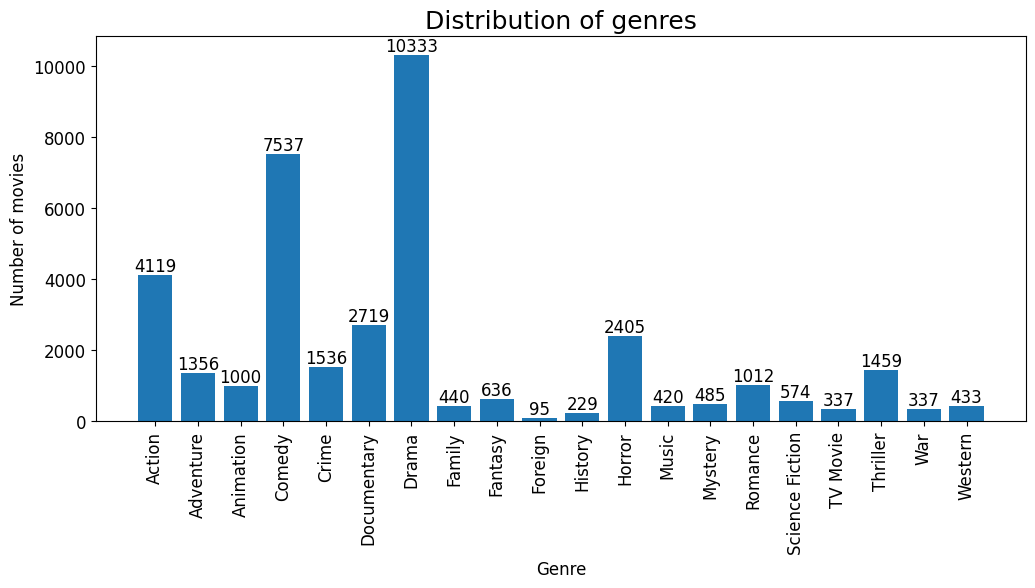

In [10]:
# Plot the distribution of the genres
def plot_genre_distribution(df: pd.DataFrame, genres: list[str], column_name: str = 'first_genre', font_size: int = 12) -> dict:
    """Plot the distribution of the genres

    Args:
        df (pd.DataFrame): Dataframe containing the genres column
        genres (list[str]): List of genres
        column_name (str, optional): Column name containing the genres. Defaults to 'first_genre'.
        font_size (int, optional): Font size. Defaults to 12.

    Returns:
        dict: The counts of the genres
    """
    genre_counts = {}
    
    # Initialize genre counts to 0
    for genre in genres:
        genre_counts[genre] = 0
    
    # Count the number of movies in each genre
    for line in df[column_name]:
        # If column_name is 'genres', count the number of movies with each genre
        if column_name == 'genres':
            for genre in line.split('|'):
                genre_counts[genre] += 1
        elif line in genre_counts:
            genre_counts[line] += 1
    
    # Plot the distribution of the genres
    plt.figure(figsize=(12, 5))
    plt.title('Distribution of genres', fontsize=font_size*1.5)
    bars = plt.bar(list(genre_counts.keys()), list(genre_counts.values()))
    
    # Add labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom', fontsize=font_size)
    
    plt.xticks(rotation=90, fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.xlabel('Genre', fontsize=font_size)
    plt.ylabel('Number of movies', fontsize=font_size)
    plt.show()
    
    return genre_counts

genres_count = plot_genre_distribution(movies_clean_df, genres, 'first_genre')

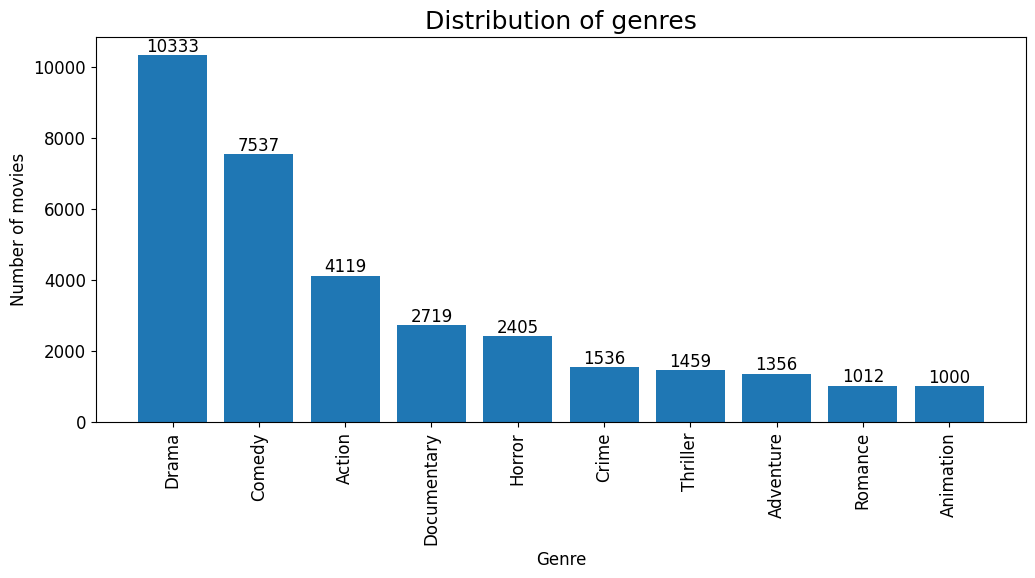

{'Drama': 10333,
 'Comedy': 7537,
 'Action': 4119,
 'Documentary': 2719,
 'Horror': 2405,
 'Crime': 1536,
 'Thriller': 1459,
 'Adventure': 1356,
 'Romance': 1012,
 'Animation': 1000}

In [11]:
GENRES_TO_KEEP = 10

# Keep the dict of genres with the highest counts
top_genres = dict(sorted(genres_count.items(), key=lambda item: item[1], reverse=True)[:GENRES_TO_KEEP])

# Remove movies with genres that are not in the top GENRES_TO_KEEP
movies_clean_df = movies_clean_df[movies_clean_df['first_genre'].isin(top_genres.keys())]

# Plot the distribution of the genres
plot_genre_distribution(movies_clean_df, top_genres.keys(), 'first_genre')


In [12]:
# Compute the mean movie per genre
# mean_movies_per_genre = movies_clean_df.groupby('first_genre').count()['title'].mean()
# print("Mean movies per genre :", mean_movies_per_genre)

# Compute the number of movies to keep per genre based on the last element of the top 10 genres
min_movies_per_genre = top_genres[list(top_genres.keys())[-1]]
print("Min movies per genre :", min_movies_per_genre)

# Limit the number of movies per genre to the mean or min
movies_clean_df = movies_clean_df.groupby('first_genre').head(int(min_movies_per_genre))

Min movies per genre : 1000


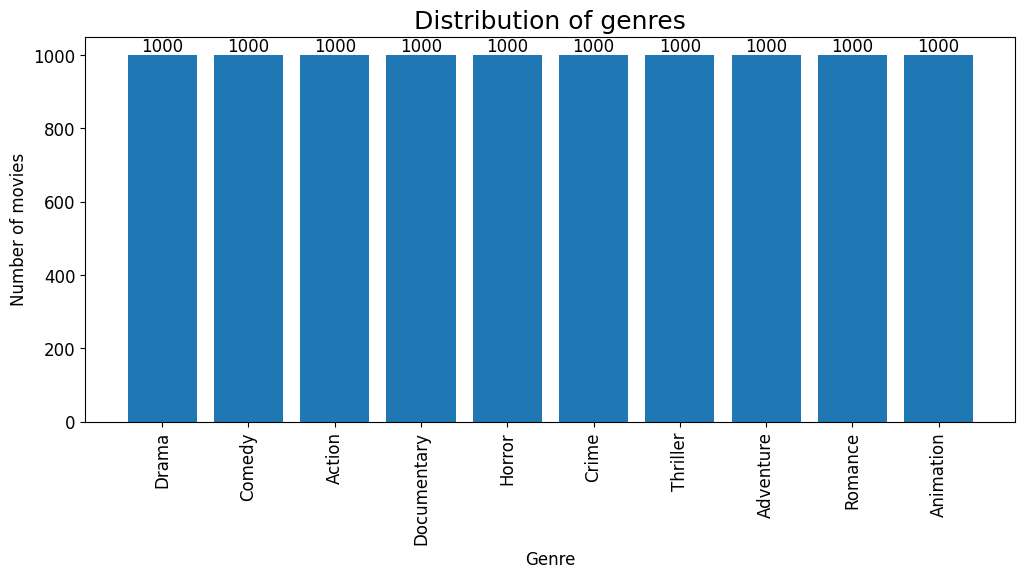

{'Drama': 1000,
 'Comedy': 1000,
 'Action': 1000,
 'Documentary': 1000,
 'Horror': 1000,
 'Crime': 1000,
 'Thriller': 1000,
 'Adventure': 1000,
 'Romance': 1000,
 'Animation': 1000}

In [13]:
# Plot the distribution of the genres
plot_genre_distribution(movies_clean_df, top_genres.keys(), 'first_genre')

In [14]:
# Define POS tags for lemmatization/stemming
EXCLUDED_POS_TAGS = [
    "DT", # determiner
    "PRP", # personal pronoun
    "PRP$", # possessive pronoun
    "WP", # wh-pronoun
    "WP$", # possessive wh-pronoun
    "CD", # cardinal number
    "CC", # coordinating conjunction
    "IN", # preposition or subordinating conjunction
    "PDT", # predeterminer
    "EX", # existential there
    "POS", # genitive marker ('s)
    "$", # currency symbol
    "(", # opening parenthesis
    ")", # closing parenthesis
    ",", # comma
    ".", # sentence terminal
    ":", # colon or ellipsis
    "--", # dash or hyphen
    "``", # opening quotation mark
    "''", # closing quotation mark
    "SYM", # symbol
    "RP", # particle
    # "NNP", # proper noun, singular
    # "NNPS", # proper noun, plural
]

In [15]:
def stemmer(text: str) -> str:
  """Stem the text using the SnowballStemmer

  Args:
      text (str): The text to stem
      
  Returns:
      str: The stemmed text
  """
  stemmer = SnowballStemmer(language='english')
  
  # List of stems
  stems = []
  
  for token,tag in pos_tag(word_tokenize(text)):
    # print(token, tag)
    if tag in EXCLUDED_POS_TAGS:
      continue
    
    # We remove the stop words
    if token not in STOP_WORDS:

      # Apply stemming on the text
      stems.append(stemmer.stem(token))

  # We return the lems as a string
  return ' '.join(stems)

movies_clean_df['overview_stem'] = movies_clean_df['overview'].apply(stemmer)

In [16]:
def lemmatize(text: str) -> str:
  """Lemmatize the text

  Args:
      text (str): The text to lemmatize
      
  Returns:
      str: The lemmatized text
  """
  wordnet = WordNetLemmatizer()
  
  # List of lems
  lems = []
  
  for token,tag in pos_tag(word_tokenize(text)):
    
    if tag in EXCLUDED_POS_TAGS:
      continue
    
    # We remove the stop words
    if token not in STOP_WORDS:
      pos=tag[0].lower()
      
      # Certains tokens can have a PoS tag that is not recognized by WordNet (e.g. an abbreviation or a typo).
      # In this case, the pos variable is initialized to 'n', which corresponds to the default nominal class of WordNet
      if pos not in ['a', 'r', 'n', 'v']:
          pos='n'
          
      # We add the lem to the list
      lems.append(wordnet.lemmatize(token,pos))
      
  # We return the lems as a string
  return ' '.join(lems)

movies_clean_df['overview_lem'] = movies_clean_df['overview'].apply(lemmatize)

In [17]:
def remove_punctuation(actual_line: str) -> str:
  """Remove punctuation characters in the given string

  Args:
      actual_line (str): The string to clean

  Returns:
      str: The string without punctuation characters
  """
  replace_char = [["'s",""], ["  ", " "]]
  for char in replace_char:
    actual_line = actual_line.replace(char[0], char[1])
    
  print(actual_line)
  return actual_line

movies_clean_df['overview_stem'] = movies_clean_df['overview_stem'].apply(remove_punctuation)
movies_clean_df['overview_lem'] = movies_clean_df['overview_lem'].apply(remove_punctuation)

led woodi andi toy live happili room andi birthday bring buzz lightyear scene afraid lose place andi heart woodi plot buzz circumst separ buzz woodi owner duo eventu learn put differ
when sibl judi peter discov enchant board game open door magic world unwit invit alan adult trap game year live room alan hope freedom finish game prove riski find run giant rhinoceros evil monkey terrifi creatur
cheat mistreat step women hold breath wait elus good man break string less-than-stellar lover friend confid vannah berni glo robin talk determin find better way breath
just georg bank recov daughter wed receiv news pregnant georg wife nina expect plan sell home plan georg chang arriv grandchild kid
obsess master thief neil mccauley lead top-notch crew various insan heist los angel mental unstabl detect vincent hanna pursu rest man recogn respect abil dedic even awar cat-and-mous game may end violenc
ugli duckl undergon remark chang still harbor feel crush carefre playboy business-focus brother som

In [18]:
# Drop rows with empty overview
movies_clean_df = movies_clean_df.drop(movies_clean_df[movies_clean_df['overview'] == ''].index)

In [19]:
# Print all the words and their occurence
get_words_occurence(movies_clean_df, 'overview_stem')
get_words_occurence(movies_clean_df, 'overview_lem')

[('find', 1586), ('life', 1467), ('film', 1385), ('young', 1374), ('new', 1244), ('man', 1225), ('get', 1208), ('year', 1180), ('love', 1173), ('live', 1119), ('friend', 1113), ('take', 1113), ('world', 1053), ('when', 1052), ('stori', 1029), ('famili', 999), ('becom', 985), ('murder', 904), ('make', 793), ('tri', 789), ('time', 787), ('woman', 783), ('old', 766), ('work', 727), ('girl', 687), ('help', 682), ('begin', 676), ('must', 675), ('meet', 674), ('come', 673), ('father', 668), ('way', 661), ('kill', 657), ('day', 652), ('back', 618), ('discov', 614), ('town', 614), ('turn', 613), ('set', 607), ('fall', 603), ('wife', 596), ('home', 572), ('first', 561), ('war', 551), ('forc', 524), ('go', 520), ('son', 517), ('follow', 510), ('want', 508), ('mysteri', 506), ('name', 498), ('death', 495), ('group', 493), ('peopl', 492), ('american', 489), ('soon', 489), ('citi', 486), ('mother', 477), ('secret', 476), ('return', 469), ('decid', 466), ('daughter', 464), ('boy', 459), ('school', 4

In [20]:
# Exporting the dataset
movies_clean_df.to_csv('movies_clean.csv', index=False)